In [9]:
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed

from aggclass import AgglomerativeEnsemble
from aggclass.helpers import stratified_sample

import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_moons
from sklearn.neighbors import KNeighborsClassifier
from sklearn.semi_supervised import LabelPropagation
from sklearn.semi_supervised import LabelSpreading

def exp(n_unlabeled=100, n_labeled_per_class=1, noise=0.1, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
        
    accuracies = np.zeros(6)
    
    n_labeled=2*n_labeled_per_class
    
    X, y = make_moons(10, noise=noise)
    X_labeled_1 = X[np.where(y == 0)[0][:n_labeled_per_class]]
    X_labeled_2 = X[np.where(y == 1)[0][:n_labeled_per_class]]
    X_labeled = np.concatenate((X_labeled_1, X_labeled_2), axis=0)
    
    del X, y
    
    y_labeled = np.concatenate((np.zeros(n_labeled_per_class), np.ones(n_labeled_per_class)))
    
    X, y = make_moons(10000, noise=noise)
    perm = np.random.choice(10000, 10000, replace=False)
    X_unlabeled = X[:n_unlabeled]
    y_unlabeled = y[:n_unlabeled]
        
    X_test, y_test = make_moons(1000, noise=noise)
    
    clf=SVC()
    clf.fit(X_labeled, y_labeled)
    y_hat=clf.predict(X_test)
    accuracies[1] = (y_test == y_hat).mean()
    
    
    clf=DecisionTreeClassifier()
    clf.fit(X_labeled, y_labeled)
    y_hat=clf.predict(X_test)
    accuracies[2] = (y_test == y_hat).mean()
    
    
    clf=KNeighborsClassifier(n_neighbors=1, metric='euclidean')
    clf.fit(X_labeled, y_labeled)
    y_hat=clf.predict(X_test)
    accuracies[3] = (y_test == y_hat).mean()

    
    y_ = -1 * np.ones(n_labeled + n_unlabeled)
    y_[:n_labeled] = y_labeled.copy()

    n_neighbors = max([1, int(np.math.floor(np.log(len(y_))))])
    clf=AgglomerativeEnsemble(n_estimators=1, p_inbag=1, affinity='euclidean', linkage='single', n_neighbors=1, gem_p=128)
    clf.fit(np.concatenate((X_labeled, X_unlabeled), axis=0), y_)
    y_hat=clf.predict(X_test)
    accuracies[0] = (y_test == y_hat).mean()
    
    clf=LabelPropagation(n_neighbors=1)
    clf.fit(np.concatenate((X_labeled, X_unlabeled), axis=0), y_)
    y_hat=clf.predict(X_test)
    accuracies[4] = (y_test == y_hat).mean()
    
    clf=LabelSpreading(n_neighbors=1)
    clf.fit(np.concatenate((X_labeled, X_unlabeled), axis=0), y_)
    y_hat=clf.predict(X_test)
    accuracies[5] = (y_test == y_hat).mean()
    
        
    print(accuracies)

    return accuracies

0.226
0.998


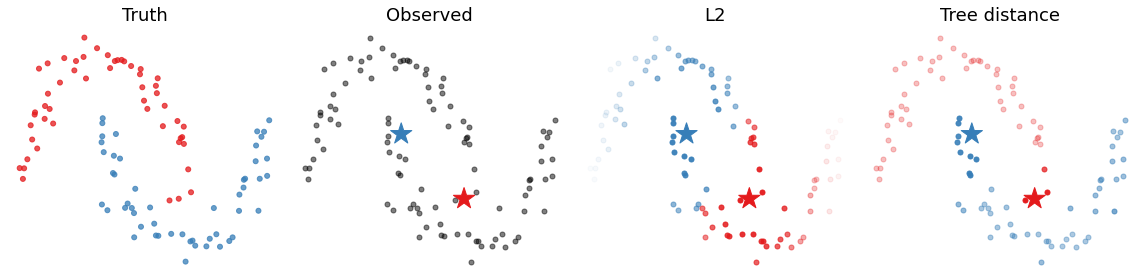

In [131]:
from sklearn.preprocessing import MinMaxScaler

fig, ax = plt.subplots(1,4, figsize=(16,4), sharex=True, sharey=True)
n_labeled=2

colors=sns.color_palette("Set1", n_colors=2)

np.random.seed(1)

fontsize=18
n_labeled_per_class=1

n_labeled=2*n_labeled_per_class
n_unlabeled=100
    
at_least_n_labeled_per_class = False
while not at_least_n_labeled_per_class:
    X_labeled, y_labeled = make_moons(n_labeled, noise=0.1)

    if len(np.where(y_labeled == 1)[0]) >= n_labeled_per_class and len(np.where(y_labeled == 0)[0]) >= n_labeled_per_class:
        at_least_n_labeled_per_class=True

X_unlabeled, y_unlabeled = make_moons(n_unlabeled, noise=0.1)
X = np.concatenate((X_labeled, X_unlabeled), axis=0)
y = np.concatenate((y_labeled, y_unlabeled))

y_ = -1 * np.ones(n_labeled + n_unlabeled)
y_[:n_labeled] = y_labeled.copy()
        
X_test, y_test = make_moons(500, noise=0.1)
s=25

clf=KNeighborsClassifier(n_neighbors=1)
clf.fit(X_labeled, y_labeled)
y_hat=clf.predict(X_test)
print((y_hat == y_test).mean())
y_hat=clf.predict(X)
ax[2].scatter(X[:, 0], X[:, 1], c=np.array(colors)[np.array([0,1])][y_hat.astype(int)], s=s, alpha=0)
ax[2].set_title('L2', fontsize=fontsize)
ax[2].scatter(X_labeled[:, 0], X_labeled[:, 1], c=np.array(colors)[np.array([0,1])][y_labeled.astype(int)], marker='*', s=500)

dists = np.stack([np.linalg.norm(X - xl, axis=1) for xl in X_labeled]).T

min_dists = np.min(dists, axis=1).reshape(-1,1)

mms = MinMaxScaler(feature_range=(0,1)).fit(min_dists)
min_dists_mms = mms.transform(min_dists)
min_dists_mms = sigmoid(min_dists_mms.flatten(), c=8)


for i, d in enumerate(min_dists_mms):
    ax[2].scatter(X[i, 0], X[i, 1], s=s, alpha=1-d, color=colors[y_hat[i]])


        
ax[0].scatter(X_unlabeled[:, 0], X_unlabeled[:, 1], c=np.array(colors)[np.array([0,1])][y_unlabeled.astype(int)], s=s, alpha=0.75)
ax[0].scatter(X_labeled[:, 0], X_labeled[:, 1], c=np.array(colors)[np.array([0,1])][y_labeled.astype(int)], s=s, alpha=0.75)
ax[0].set_title('Truth', fontsize=fontsize)

ax[1].scatter(X_unlabeled[:, 0], X_unlabeled[:, 1], c='k', s=s, alpha=0.5)
ax[1].scatter(X_labeled[:, 0], X_labeled[:, 1], c=np.array(colors)[np.array([0,1])][y_labeled.astype(int)], marker='*', s=500)
ax[1].set_title('Observed', fontsize=fontsize)

clf=AgglomerativeEnsemble(n_estimators=1, p_inbag=1, affinity='euclidean', linkage='single', 
                          n_neighbors=1, gem_p=32, classes=np.array([0,1]))
clf.fit(X, y_)
y_hat=clf.predict(X_test)
print((y_hat == y_test).mean())
y_hat=clf.predict(X)
ax[3].scatter(X[:, 0], X[:, 1], c=np.array(colors)[np.array([0,1])][y_hat.astype(int)], s=s, alpha=0)
ax[3].set_title('Tree distance', fontsize=fontsize)
ax[3].scatter(X_labeled[:, 0], X_labeled[:, 1], c=np.array(colors)[np.array([0,1])][y_labeled.astype(int)], marker='*', s=500)

tree_dists =  normalize(clf.ensemble[0].tree_distances, axis=1, norm='l1')

min_tree_dists = np.min(tree_dists, axis=1).reshape(-1,1)
mms = MinMaxScaler(feature_range=(0,1)).fit(min_tree_dists)
min_tree_dists_mms = mms.transform(min_tree_dists)

min_tree_dists = sigmoid(min_tree_dists, c=20)


for i, mtd in enumerate(min_tree_dists):
    ax[3].scatter(X[i, 0], X[i, 1], s=s, color=colors[y_hat[i]], alpha=1-mtd)
    
for ax_ in ax:
    ax_.set_yticks([])
    ax_.set_xticks([])
    ax_.spines['top'].set_visible(False)
    ax_.spines['right'].set_visible(False)
    ax_.spines['bottom'].set_visible(False)
    ax_.spines['left'].set_visible(False)


plt.tight_layout()
plt.savefig('figures/comparing_distances.pdf')

In [124]:
sigmoid(min_tree_dists, c=15)

array([5.21445691e-04, 5.21445691e-04, 9.94432539e-01, 9.94432539e-01,
       6.87545583e-01, 9.93844151e-01, 9.94242330e-01, 4.78353670e-02,
       9.94343164e-01, 9.94343164e-01, 8.01153458e-03, 2.71647262e-02,
       1.01859457e-01, 9.94343164e-01, 8.16603050e-01, 2.71647262e-02,
       4.78353670e-02, 9.93666052e-01, 9.93200549e-01, 8.01153458e-03,
       9.94432539e-01, 9.94512290e-01, 9.94432539e-01, 5.87705209e-01,
       5.04033569e-03, 1.60066789e-03, 1.41509226e-01, 8.16603050e-01,
       8.01153458e-03, 1.01859457e-01, 3.14145470e-02, 7.31527959e-04,
       7.08918425e-02, 2.26443394e-03, 6.87545583e-01, 2.01807443e-02,
       7.08918425e-02, 9.94512290e-01, 8.01153458e-03, 4.78353670e-02,
       1.17576834e-03, 9.94760513e-01, 7.62296177e-01, 9.94707113e-01,
       9.94707113e-01, 1.41509226e-01, 9.93996288e-01, 9.94242330e-01,
       2.01807443e-02, 1.01859457e-01, 9.94432539e-01, 9.93666052e-01,
       9.94512290e-01, 3.14145470e-02, 1.01859457e-01, 3.21539699e-03,
      

In [39]:
from math import sigmoid

ImportError: cannot import name 'sigmoid'

In [70]:
def sigmoid(a, c=1):
    mean = np.mean(a)
    return np.array([1 / (1 + np.math.exp(-c * (x - mean))) for x in a])

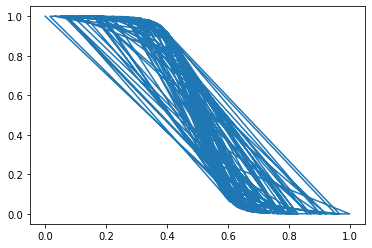

In [78]:
a = min_dists_mms
plt.plot(a, 1 - sigmoid(a, c=25))

In [88]:
tree_distances = clf.ensemble[0].tree_distances

In [111]:
from scipy.special import softmax
from sklearn.preprocessing import normalize

scores = tree_distances
# scores = 1 / scores
scores = 1 - normalize(scores, axis=1, norm='l1')